# Homework 1

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Aman Krishna
* amank@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


You can find more details on US treasury instruments in the FINM 37400 Fixed Income course.



In [146]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Problem 1: Explore symbology for US treasuries and corporate bonds

## a. Load and explore US government bonds symbology data

Load the `govt_symbology` Excel file into a dataframe. For each government bond issue, calculate its initial term/time-to-maturity in years (based on issue date and maturity date), as well as the current time-to-maturity. Assume a year has 365.25 days, or use QuantLib yearFraction() function.

In [147]:
govt_symbology = pd.read_excel('../data/govt_symbology.xlsx')
govt_symbology.head()

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,dcc,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency
0,B,Govt,BBG01FSQGRT9,US912796CQ02,TSRYS5551439,B 09/14/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2023-03-16,NaT,NaT,2023-09-14,US,USD
1,B,Govt,BBG01FY3YC89,US912796CR84,TSRYS5554749,B 09/21/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2023-03-23,NaT,NaT,2023-09-21,US,USD
2,B,Govt,BBG01G14BS72,US912796CS67,TSRYS5557561,B 09/28/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2023-03-30,NaT,NaT,2023-09-28,US,USD
3,B,Govt,BBG01BYWNTS7,US912796CU14,TSRYS5513508,B 04/18/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2022-12-20,NaT,NaT,2023-04-18,US,USD
4,B,Govt,BBG01C3GB4X6,US912796CV96,TSRYS5516304,B 04/25/23,TREASURY BILL,US GOVERNMENT,0.0,ZERO,ACT/360,NaN,1,2022-12-27,NaT,NaT,2023-04-25,US,USD


In [148]:
# Calculate initial term and current time-to-maturity for each bond issue
def get_symbology(df, underlying=False):
    for index, row in df.iterrows():
        start_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        today_date = ql.Date(14,4,2023)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        #set dcc as Actual/365.25
        dcc = ql.Actual36525()
        initial_term = dcc.yearFraction(start_date, maturity_date)
        current_time_to_maturity = dcc.yearFraction(today_date, maturity_date)
        df.at[index, 'term'] = initial_term
        df.at[index, 'TTM'] = current_time_to_maturity

    if underlying:
        return df[['ticker','figi','security','name','und_bench_isin','coupon','start_date', 'maturity', 'term', 'TTM']]
    else:
        #round term to integer
        df['term'] = df['term'].apply(np.ceil)
        df1 = df[['ticker','figi','security','name','coupon','start_date', 'maturity', 'term', 'TTM']]
        return df1

In [149]:
govt_symbology1 = get_symbology(govt_symbology)

In [150]:
govt_symbology1

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM
0,B,BBG01FSQGRT9,B 09/14/23,TREASURY BILL,0.000,2023-03-16,2023-09-14,1.0,0.418891
1,B,BBG01FY3YC89,B 09/21/23,TREASURY BILL,0.000,2023-03-23,2023-09-21,1.0,0.438056
2,B,BBG01G14BS72,B 09/28/23,TREASURY BILL,0.000,2023-03-30,2023-09-28,1.0,0.457221
3,B,BBG01BYWNTS7,B 04/18/23,TREASURY BILL,0.000,2022-12-20,2023-04-18,1.0,0.010951
4,B,BBG01C3GB4X6,B 04/25/23,TREASURY BILL,0.000,2022-12-27,2023-04-25,1.0,0.030116
...,...,...,...,...,...,...,...,...,...
377,T,BBG01FQJ5MY4,T 4 5/8 03/15/26,US TREASURY N/B,4.625,2023-03-15,2026-03-15,4.0,2.918549
378,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,8.0,6.962355
379,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,6.0,4.963723
380,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,3.0,1.963039


## b. Historical time series of US treasury coupons 

Plot the time series of coupons for for US treasury notes/bonds issued in the last 10 years (indexed by issue date). 
What can you say about the overall level of the coupons in the last 2 years?


In [151]:
#filter out the start dates older than 10 years from 04/14/2023
govt_symbology_plot = govt_symbology1[govt_symbology1['term'] <= 10]
#remove all the zero coupon bonds
govt_symbology_plot = govt_symbology_plot[govt_symbology_plot['coupon'] != 0]

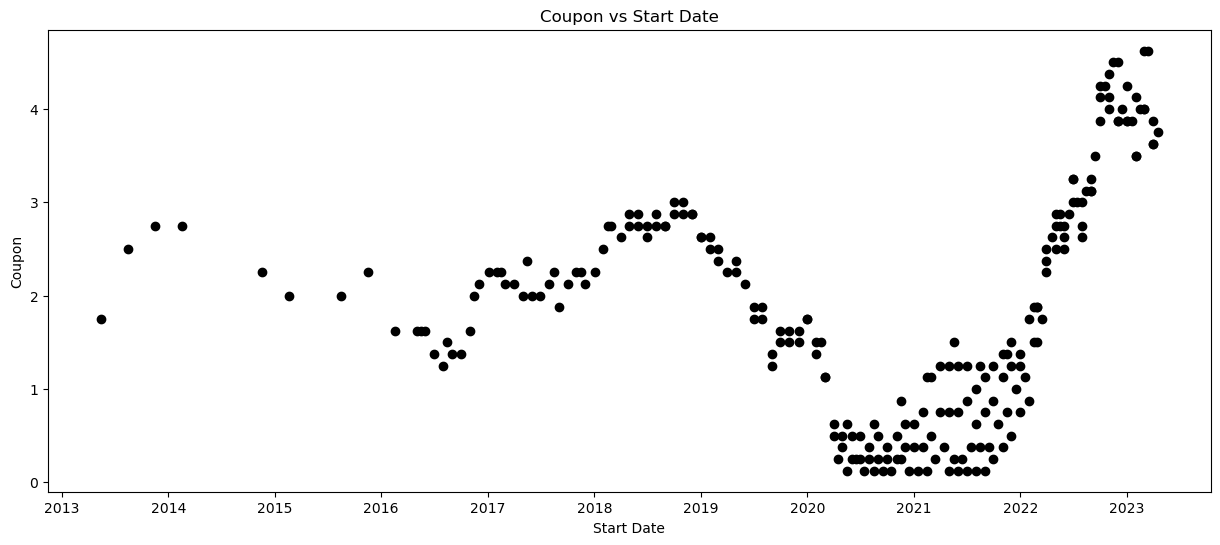

In [152]:
#create scatter plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_plot['start_date'], govt_symbology_plot['coupon'], color='black')
ax.set_xlabel('Start Date')
ax.set_ylabel('Coupon')
ax.set_title('Coupon vs Start Date')
plt.show()

> We see the coupons since 2013 (peaked around 3% in 2018) and have been declining since then.
>
> But since the beginning of 2022, the coupons have been increasing again. This is consistent with the Fed's current policy of raising interest rates.

## c. Load the on-the-run US treasuries

Load the `govt_on_the_run` Excel file into a dataframe. Select the current on-the-run 2Y, 3Y, 5Y, 7Y, 10Y, 20Y and 30Y issues (off-the-run issues have the B & C suffix). Create a separate symbology dataframe for on-the-run treasuries only, to be used later on for the on-the-run government yield curve bootstrapping.

In [153]:
gov_otr = pd.read_excel('../data/govt_on_the_run.xlsx')
gov_otr.head()

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT10B Govt,2023-04-14,US91282CFV81,BBG01BC373F4
2,GT10C Govt,2023-04-14,US91282CFF32,BBG01920ZBH5
3,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
4,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1


>Removing the off-the-run issues, we are left with the following on-the-run issues:

In [154]:
#Check if the ticker has "B" or "C" in it and filter them out
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('B')]
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('C')]
gov_otr.reset_index(drop=True, inplace=True)

In [155]:
gov_otr

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
2,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1
3,GT3 Govt,2023-04-14,US91282CGV72,BBG01G5ZMM43
4,GT30 Govt,2023-04-14,US912810TN81,BBG01DVKBH56
5,GT5 Govt,2023-04-14,US91282CGT27,BBG01G14BW91
6,GT7 Govt,2023-04-14,US91282CGS44,BBG01G14BV75


In [156]:
gov_otr_symbology = govt_symbology[govt_symbology['isin'].isin(gov_otr['isin'])]

In [157]:
#sort by TTM
gov_otr_symbology.sort_values(by=['TTM'], inplace=True)

In [158]:
gov_otr_symbology1 = get_symbology(gov_otr_symbology)
gov_otr_symbology1

,ticker,figi,security,name,coupon,start_date,maturity,term,TTM
380,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,3.0,1.963039
381,T,BBG01G5ZMM43,T 3 3/4 04/15/26,US TREASURY N/B,3.750,2023-04-17,2026-04-15,3.0,3.003422
379,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,6.0,4.963723
378,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,8.0,6.962355
373,T,BBG01DVKBC66,T 3 1/2 02/15/33,US TREASURY N/B,3.500,2023-02-15,2033-02-15,11.0,9.842574
139,T,BBG01F6N6GN1,T 3 7/8 02/15/43,US TREASURY N/B,3.875,2023-02-28,2043-02-15,20.0,19.841205
138,T,BBG01DVKBH56,T 3 5/8 02/15/53,US TREASURY N/B,3.625,2023-02-15,2053-02-15,31.0,29.842574


## d. Load and explore US corporate bonds symbology data

Load the `corp_symbology` Excel file into a dataframe. 

Create a new (filtered) dataframe for 
* bullet/non-callable (mty_typ="AT MATURITY"), 
* senior unsecured (rank = "Sr Unsecured"),
* fixed coupon (cpn_type="FIXED")

bonds only, with following columns:



| ticker | figi | security | name | coupon | start_date | maturity | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

where 
* `term` refers to the initial term/time-to-maturity in years
* `TTM` refers to the current time-to-maturity in years

Create a separate dataframe for VZ issuer only.

In [159]:
corp_sym = pd.read_excel('../data/corp_symbology.xlsx')
corp_sym.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,US91282CGM73,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.550,...,2,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,AT MATURITY,Sr Unsecured,US,USD
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,US91282CGM73,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.200,...,2,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,AT MATURITY,Sr Unsecured,US,USD


In [160]:
corp_symbology = corp_sym[(corp_sym['mty_typ'] == 'AT MATURITY') & (corp_sym['rank'] == 'Sr Unsecured') & (corp_sym['cpn_type'] == 'FIXED')]

In [161]:
corp_symbology = get_symbology(corp_symbology, underlying=True)
corp_symbology

,ticker,figi,security,name,und_bench_isin,coupon,start_date,maturity,term,TTM
3,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,US91282CGM73,6.550,2019-11-22,2033-03-15,13.311431,9.919233
4,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,US91282CGM73,6.200,2019-11-22,2034-12-15,15.063655,11.671458
5,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,US91282CGM73,6.400,2019-11-22,2035-12-15,16.062971,12.670773
6,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,US91282CGM73,6.150,2019-11-22,2037-03-01,17.273101,13.880903
7,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,US91282CGM73,6.650,2019-11-22,2037-11-15,17.982204,14.590007
...,...,...,...,...,...,...,...,...,...,...
201,VZ,BBG00HC11V79,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,US91282CGM73,4.500,2017-08-10,2033-08-10,16.000000,10.324435
202,VZ,BBG00JKZK9K4,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,US91282CGU99,3.376,2018-01-19,2025-02-15,7.074606,1.842574
203,VZ,BBG00M1BQWX0,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,US91282CGT27,4.329,2018-10-22,2028-09-21,9.916496,5.440110
221,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,US91282CGU99,0.750,2021-03-22,2024-03-22,3.000684,0.939083


In [162]:
corp_symbology_VZ = corp_symbology[corp_symbology['ticker'] == 'VZ']
corp_symbology_VZ

,ticker,figi,security,name,und_bench_isin,coupon,start_date,maturity,term,TTM
181,VZ,BBG00000BHR9,VZ 6 1/4 04/01/37,VERIZON COMMUNICATIONS,US91282CGM73,6.250,2007-04-03,2037-04-01,29.995893,13.965777
182,VZ,BBG0000M1DD6,VZ 6.4 02/15/38,VERIZON COMMUNICATIONS,US91282CGM73,6.400,2008-02-12,2038-02-15,30.009582,14.841889
183,VZ,BBG0027BCJ08,VZ 4 3/4 11/01/41,VERIZON COMMUNICATIONS,US912810TQ13,4.750,2011-11-03,2041-11-01,29.995893,18.551677
185,VZ,BBG00580D503,VZ 6.4 09/15/33,VERIZON COMMUNICATIONS,US91282CGM73,6.400,2013-09-18,2033-09-15,19.991786,10.422998
186,VZ,BBG00580DD79,VZ 6.55 09/15/43,VERIZON COMMUNICATIONS,US912810TQ13,6.550,2013-09-18,2043-09-15,29.990418,20.421629
187,VZ,BBG0083CP3G1,VZ 4.862 08/21/46,VERIZON COMMUNICATIONS,US912810TQ13,4.862,2015-03-11,2046-08-21,31.446954,23.353867
188,VZ,BBG0083CP816,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,US912810TL26,5.012,2015-03-11,2054-08-21,39.446954,31.353867
191,VZ,BBG009PNV1G8,VZ 4.272 01/15/36,VERIZON COMMUNICATIONS,US91282CGM73,4.272,2015-08-20,2036-01-15,20.405202,12.755647
192,VZ,BBG009PNW3Z2,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,US912810TL26,4.522,2015-08-20,2048-09-15,33.073238,25.423682
193,VZ,BBG009PNW578,VZ 4.672 03/15/55,VERIZON COMMUNICATIONS,US912810TL26,4.672,2015-08-20,2055-03-15,39.567420,31.917864


# Problem 2: Explore EOD market prices and yields

## a. Load and explore treasury market prices and yields

Load the `market_prices_eod` Excel file into a dataframe. It provides market data for US treasuries and corporate bonds of 2023-04-14.

Join the treasuries symbology dataframe with the market data, to add the following columns:


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of treasury mid yields by TTM.


In [163]:
md = pd.read_excel('../data/market_prices_eod.xlsx')
md

,date,class,ticker,isin,figi,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.6780,98.8480,98.7630,99.1020,4.679,4.551
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.4540,98.8210,98.6370,98.6680,4.361,4.203
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.0900,97.3690,97.2300,98.6640,4.260,4.174
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.1630,115.9840,115.5740,116.1740,4.624,4.529
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.9390,113.5860,113.2620,115.3800,4.742,4.674
...,...,...,...,...,...,...,...,...,...,...,...
592,2023-04-14,Govt,T,US91282CGR60,BBG01FQJ5MY4,102.1250,102.1563,102.1406,102.5547,3.845,3.834
593,2023-04-14,Govt,T,US91282CGS44,BBG01G14BV75,100.3750,100.4375,100.4063,100.5742,3.563,3.553
594,2023-04-14,Govt,T,US91282CGT27,BBG01G14BW91,100.0703,100.0859,100.0781,100.2461,3.609,3.606
595,2023-04-14,Govt,T,US91282CGU99,BBG01G14BXX2,99.5703,99.5820,99.5762,99.7559,4.105,4.099


In [164]:
#merge the govt_symbology1 with the market data (md) on figi
govt_symbology_md = pd.merge(govt_symbology1, md, on='figi', how='inner')
#change mid_clean column name to "mid"
govt_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
govt_symbology_md

,ticker_x,figi,security,name,coupon,start_date,maturity,term,TTM,date,class,ticker_y,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield
0,T,BBG000DLJF04,T 6 1/4 08/15/23,US TREASURY N/B,6.250,1993-08-16,2023-08-15,30.0,0.336756,2023-04-14,Govt,T,US912810EQ77,100.4375,100.8750,100.6563,101.7090,4.858,3.542
1,T,BBG000DKZWK9,T 7 1/2 11/15/24,US TREASURY N/B,7.500,1994-08-15,2024-11-15,31.0,1.590691,2023-04-14,Govt,T,US912810ES34,104.7695,105.2148,104.9922,108.1621,4.336,4.051
2,T,BBG000DLBVY0,T 7 5/8 02/15/25,US TREASURY N/B,7.625,1995-02-15,2025-02-15,31.0,1.842574,2023-04-14,Govt,T,US912810ET17,105.9258,106.3477,106.1367,107.4219,4.224,3.992
3,T,BBG000DQQNJ8,T 6 7/8 08/15/25,US TREASURY N/B,6.875,1995-08-15,2025-08-15,31.0,2.338125,2023-04-14,Govt,T,US912810EV62,106.2578,106.9297,106.5938,107.7520,4.032,3.740
4,T,BBG000DPXMD0,T 6 02/15/26,US TREASURY N/B,6.000,1996-02-15,2026-02-15,31.0,2.841889,2023-04-14,Govt,T,US912810EW46,105.4453,106.0547,105.7500,106.7617,3.946,3.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,T,BBG01FQJ5MY4,T 4 5/8 03/15/26,US TREASURY N/B,4.625,2023-03-15,2026-03-15,4.0,2.918549,2023-04-14,Govt,T,US91282CGR60,102.1250,102.1563,102.1406,102.5547,3.845,3.834
328,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,8.0,6.962355,2023-04-14,Govt,T,US91282CGS44,100.3750,100.4375,100.4063,100.5742,3.563,3.553
329,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,6.0,4.963723,2023-04-14,Govt,T,US91282CGT27,100.0703,100.0859,100.0781,100.2461,3.609,3.606
330,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,3.0,1.963039,2023-04-14,Govt,T,US91282CGU99,99.5703,99.5820,99.5762,99.7559,4.105,4.099


>Since the mid yields are not given, we calculate the mid yields using the mid price quoted.
>
>We will use the quoted clean price to calculate YTM, but the argument could also be made to use the dirty price.

In [165]:
#functinalize above codes to get the implied yield from the mid price
def get_mid_yield(df):
    for index, row in df.iterrows():
        issue_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        settle_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        coupon_freq = ql.Semiannual
        coupon_term = ql.Period(coupon_freq)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        day_counter = ql.Unadjusted
        date_generation = ql.DateGeneration.Backward
        month_end = False

        schedule = ql.Schedule(issue_date,
                               settle_date,
                               coupon_term,
                               calendar,
                               day_counter,
                               day_counter,
                               date_generation,
                               month_end)

        calc_date = ql.Date(14, 4, 2023)
        ql.Settings.instance().evaluationDate = calc_date

        coupon_rate = row['coupon']/100
        day_count = ql.Thirty360(ql.Thirty360.USA)
        coupons = [coupon_rate]

        settlement_days = 1
        face_value = 100

        fixed_rate_bond = ql.FixedRateBond(
            settlement_days,
            face_value,
            schedule,
            coupons,
            day_count)

        bp1 = row['mid']
        compounding = ql.Compounded

        settle_date = fixed_rate_bond.settlementDate(calc_date)
        day_count = fixed_rate_bond.dayCounter()

        implied_yield = fixed_rate_bond.bondYield(bp1, day_count, compounding, coupon_freq, settle_date) * 100
        df.at[index, 'mid_yield'] = implied_yield
    return df

In [166]:
govt_symbology_md1 = get_mid_yield(govt_symbology_md)

In [167]:
# keep only the columns we need | date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM | in govt_symbology_md1
govt_symbology_md2 = govt_symbology_md1[['date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'term', 'TTM']]

In [168]:
#sort mid_yield in ascending order
govt_symbology_md2.sort_values(by=['mid_yield'], inplace=True)
#drop the rows with mid_yield = 0
govt_symbology_md2 = govt_symbology_md2[govt_symbology_md2['mid_yield'] != 0]
#drop the rows with mid_yield = NaN
govt_symbology_md2 = govt_symbology_md2.dropna(subset=['mid_yield'])
#reset index
govt_symbology_md2.reset_index(drop=True, inplace=True)

In [169]:
govt_symbology_md2

,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,2023-04-14,86.9219,86.9844,86.9531,3.497,3.488,3.357337,10.0,8.084873
1,2023-04-14,110.7813,111.0938,110.9375,3.452,3.424,3.437713,30.0,12.840520
2,2023-04-14,84.1719,84.2344,84.2031,3.448,3.438,3.440780,10.0,7.841205
3,2023-04-14,82.8281,82.8906,82.8594,3.472,3.461,3.466356,10.0,7.589322
4,2023-04-14,113.6250,113.9375,113.7813,3.499,3.472,3.483808,31.0,13.842574
...,...,...,...,...,...,...,...,...,...
326,2023-04-14,96.8984,96.9766,96.9375,4.924,4.819,4.891896,2.0,0.799452
327,2023-04-14,98.6758,98.7461,98.7109,5.016,4.820,4.907773,7.0,0.380561
328,2023-04-14,98.9219,98.9961,98.9590,5.008,4.746,4.952487,7.0,0.295688
329,2023-04-14,98.3906,98.4766,98.4336,5.060,4.793,5.002103,3.0,0.336756


> Plotting all the treasuries

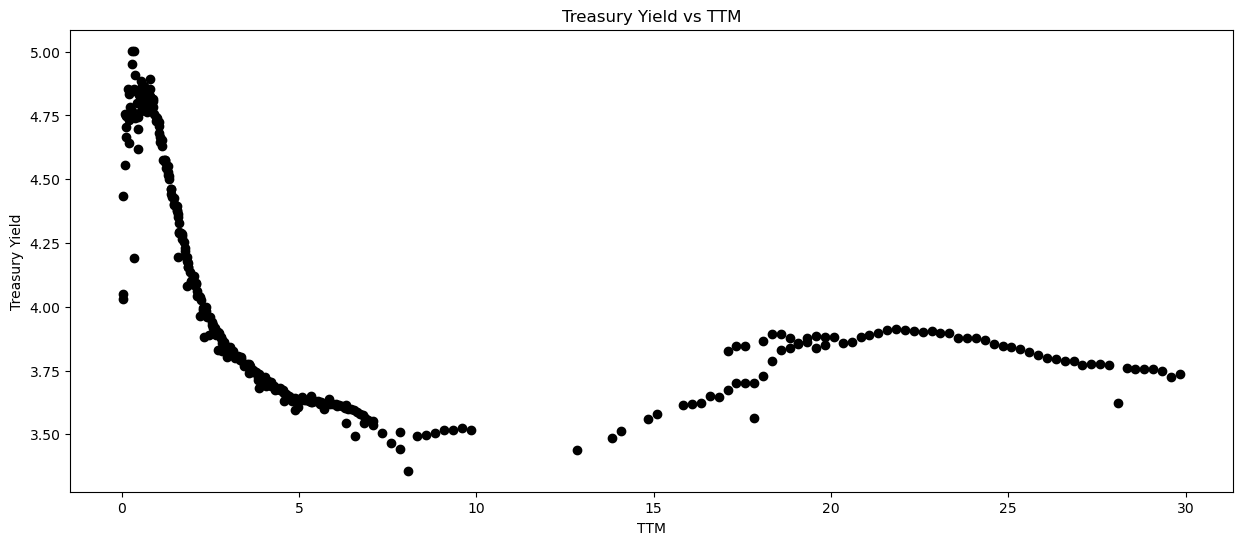

In [170]:
#plot all the govt_symbology_md2
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_md2['TTM'], govt_symbology_md2['mid_yield'], color='black')
ax.set_xlabel('TTM')
ax.set_ylabel('Treasury Yield')
ax.set_title('Treasury Yield vs TTM')
plt.show()

## b. Explore on-the-run treasuries only
Create a separate joint dataframe for on-the-run treasuries only.

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

In [171]:
#merge the gov_otr_symbology1 with the market data (md) on figi
gov_otr_symbology_md = pd.merge(gov_otr_symbology1, md, on='figi', how='inner')
#change mid_clean column name to "mid"
gov_otr_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
gov_otr_symbology_md

,ticker_x,figi,security,name,coupon,start_date,maturity,term,TTM,date,class,ticker_y,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield
0,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,2023-03-31,2025-03-31,3.0,1.963039,2023-04-14,Govt,T,US91282CGU99,99.5703,99.5820,99.5762,99.7559,4.105,4.099
1,T,BBG01G5ZMM43,T 3 3/4 04/15/26,US TREASURY N/B,3.750,2023-04-17,2026-04-15,3.0,3.003422,2023-04-14,Govt,T,US91282CGV72,99.7578,99.7734,99.7656,99.7852,3.836,3.831
2,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,2023-03-31,2028-03-31,6.0,4.963723,2023-04-14,Govt,T,US91282CGT27,100.0703,100.0859,100.0781,100.2461,3.609,3.606
3,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,2023-03-31,2030-03-31,8.0,6.962355,2023-04-14,Govt,T,US91282CGS44,100.3750,100.4375,100.4063,100.5742,3.563,3.553
4,T,BBG01DVKBC66,T 3 1/2 02/15/33,US TREASURY N/B,3.500,2023-02-15,2033-02-15,11.0,9.842574,2023-04-14,Govt,T,US91282CGM73,99.8438,99.8906,99.8672,100.4570,3.519,3.513
5,T,BBG01F6N6GN1,T 3 7/8 02/15/43,US TREASURY N/B,3.875,2023-02-28,2043-02-15,20.0,19.841205,2023-04-14,Govt,T,US912810TQ13,100.2969,100.3750,100.3359,100.9883,3.853,3.847
6,T,BBG01DVKBH56,T 3 5/8 02/15/53,US TREASURY N/B,3.625,2023-02-15,2053-02-15,31.0,29.842574,2023-04-14,Govt,T,US912810TN81,97.9531,98.0313,97.9922,98.6035,3.739,3.735


In [172]:
gov_otr_symbology_md1 = get_mid_yield(gov_otr_symbology_md)

In [173]:
# keep only the columns we need | date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM | in govt_otr_symbology_md1
gov_otr_symbology_md2 = gov_otr_symbology_md1[['date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'term', 'TTM']]

In [174]:
gov_otr_symbology_md2

,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,2023-04-14,99.5703,99.5820,99.5762,4.105,4.099,4.101802,3.0,1.963039
1,2023-04-14,99.7578,99.7734,99.7656,3.836,3.831,3.833604,3.0,3.003422
2,2023-04-14,100.0703,100.0859,100.0781,3.609,3.606,3.607215,6.0,4.963723
3,2023-04-14,100.3750,100.4375,100.4063,3.563,3.553,3.556821,8.0,6.962355
4,2023-04-14,99.8438,99.8906,99.8672,3.519,3.513,3.515423,11.0,9.842574
5,2023-04-14,100.2969,100.3750,100.3359,3.853,3.847,3.849473,20.0,19.841205
6,2023-04-14,97.9531,98.0313,97.9922,3.739,3.735,3.736185,31.0,29.842574


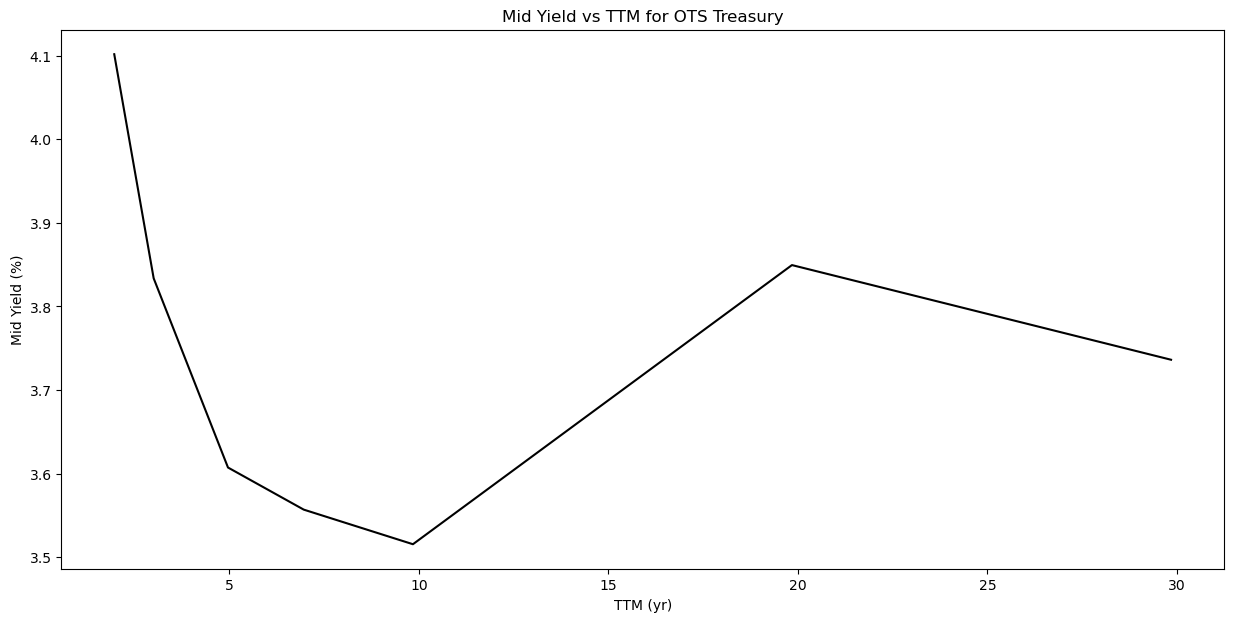

In [175]:
#scatter plot of OTR treasury mid_yield vs TTM for gov_otr_symbology_md2
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(gov_otr_symbology_md2['TTM'], gov_otr_symbology_md2['mid_yield'], color='black')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for OTS Treasury')
plt.show()

## c. Load and explore corporate bond market prices and yields

Join the filtered corporate bonds symbology dataframe with the market data, to add the following columns:


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

List the unique tickers/issuers available in the dataframe.

In [176]:
#merge the corp_symbology with the market data (md) on figi
corp_symbology_md = pd.merge(corp_symbology, md, on='figi', how='inner')
#change mid_clean column name to "mid" & rename "ticker_x" to "ticker"
corp_symbology_md.rename(columns={'mid_clean': 'mid', 'ticker_x': 'ticker'}, inplace=True)
#drop "ticker_y" column
corp_symbology_md.drop(columns=['ticker_y'], inplace=True)
corp_symbology_md

,ticker,figi,security,name,und_bench_isin,coupon,start_date,maturity,term,TTM,date,class,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,US91282CGM73,6.550,2019-11-22,2033-03-15,13.311431,9.919233,2023-04-14,Corp,US254687DV52,115.163,115.984,115.574,116.174,4.624,4.529
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,US91282CGM73,6.200,2019-11-22,2034-12-15,15.063655,11.671458,2023-04-14,Corp,US254687DZ66,112.939,113.586,113.262,115.380,4.742,4.674
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,US91282CGM73,6.400,2019-11-22,2035-12-15,16.062971,12.670773,2023-04-14,Corp,US254687EB89,114.645,115.438,115.042,117.229,4.838,4.761
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,US91282CGM73,6.150,2019-11-22,2037-03-01,17.273101,13.880903,2023-04-14,Corp,US254687EF93,111.153,112.380,111.767,112.570,5.023,4.908
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,US91282CGM73,6.650,2019-11-22,2037-11-15,17.982204,14.590007,2023-04-14,Corp,US254687EH59,118.135,119.168,118.652,121.478,4.895,4.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,VZ,BBG00HC11V79,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,US91282CGM73,4.500,2017-08-10,2033-08-10,16.000000,10.324435,2023-04-14,Corp,US92343VEA89,96.081,96.791,96.436,97.286,4.990,4.899
84,VZ,BBG00JKZK9K4,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,US91282CGU99,3.376,2018-01-19,2025-02-15,7.074606,1.842574,2023-04-14,Corp,US92343VEN01,97.932,98.164,98.048,98.639,4.567,4.432
85,VZ,BBG00M1BQWX0,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,US91282CGT27,4.329,2018-10-22,2028-09-21,9.916496,5.440110,2023-04-14,Corp,US92343VER15,98.655,99.025,98.840,99.165,4.611,4.533
86,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,US91282CGU99,0.750,2021-03-22,2024-03-22,3.000684,0.939083,2023-04-14,Corp,US92343VGF58,95.975,96.327,96.151,96.205,5.251,4.846


In [177]:
#prin the unirque tickers in corp_symbology_md
corp_symbology_md['ticker'].unique()

array(['DIS', 'IBM', 'MS', 'ORCL', 'VZ'], dtype=object)

>We have five companies with bonds in the given dataframe.

In [178]:
#Use the function get_mid_yield to get the implied yield from the mid price
corp_symbology_md1 = get_mid_yield(corp_symbology_md)

In [179]:
# keep only the columns we need | date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM | in corp_symbology_md1
corp_symbology_md2 = corp_symbology_md1[['ticker','date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'term', 'TTM','und_bench_isin']]

In [180]:
#sort mid_yield in ascending order
corp_symbology_md2.sort_values(by=['mid_yield'], inplace=True)
#drop the rows with mid_yield = 0
corp_symbology_md2 = corp_symbology_md2[corp_symbology_md2['mid_yield'] != 0]
#drop the rows with mid_yield = NaN
corp_symbology_md2 = corp_symbology_md2.dropna(subset=['mid_yield'])
#sort TTM in ascending order
corp_symbology_md2.sort_values(by=['TTM'], inplace=True)
#reset index
corp_symbology_md2.reset_index(drop=True, inplace=True)

In [181]:
corp_symbology_md2

,ticker,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM,und_bench_isin
0,DIS,2023-04-14,100.087,100.179,100.133,4.760,0.793,3.434555,4.101300,0.032854,US912796YJ21
1,MS,2023-04-14,99.685,99.779,99.732,5.561,4.973,5.284774,9.971253,0.169747,US912796YJ21
2,ORCL,2023-04-14,99.568,99.825,99.697,5.385,4.316,4.754907,9.995893,0.251882,US912796YJ21
3,IBM,2023-04-14,99.443,99.709,99.576,5.313,4.373,4.853343,9.998631,0.298426,US912797LL96
4,DIS,2023-04-14,101.739,102.165,101.952,5.354,4.782,5.040122,4.837782,0.769336,US91282CGU99
...,...,...,...,...,...,...,...,...,...,...,...
83,VZ,2023-04-14,94.636,95.983,95.309,5.367,5.275,5.320391,39.446954,31.353867,US912810TL26
84,VZ,2023-04-14,89.255,90.454,89.855,5.380,5.295,5.336722,39.567420,31.917864,US912810TL26
85,DIS,2023-04-14,131.152,134.810,132.981,6.003,5.836,5.918228,76.700890,72.632444,US912810TL26
86,DIS,2023-04-14,134.389,136.554,135.471,6.120,6.021,6.069586,77.579740,73.511294,US912810TL26


## d. Yield curve plots

Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).

Add a separate line for on-the-run US treasury yield curve (risk free curve).

What can you say about the credit issuer yields, compared to US treasury yields?

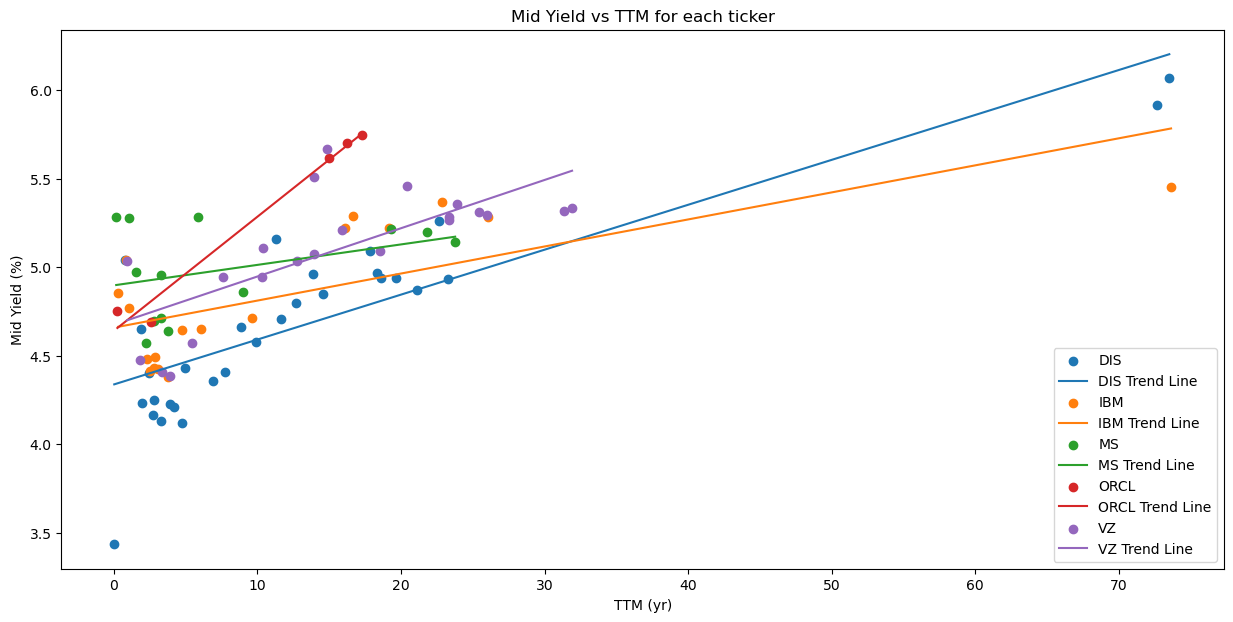

In [182]:
#Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).
#group by the data by ticker and plot the mid_yield vs TTM for each ticker
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md2.groupby('ticker'):
    ax.scatter(group['TTM'], group['mid_yield'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['mid_yield'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for each ticker')
plt.legend()
plt.show()

#### Another plot with the corporate bonds yields and the on-the-run treasury yields dropping the long end 70 yr corporate bonds for better visualization.

In [183]:
#drop TTM > 35
corp_symbology_md3 = corp_symbology_md2[corp_symbology_md2['TTM'] <= 35]

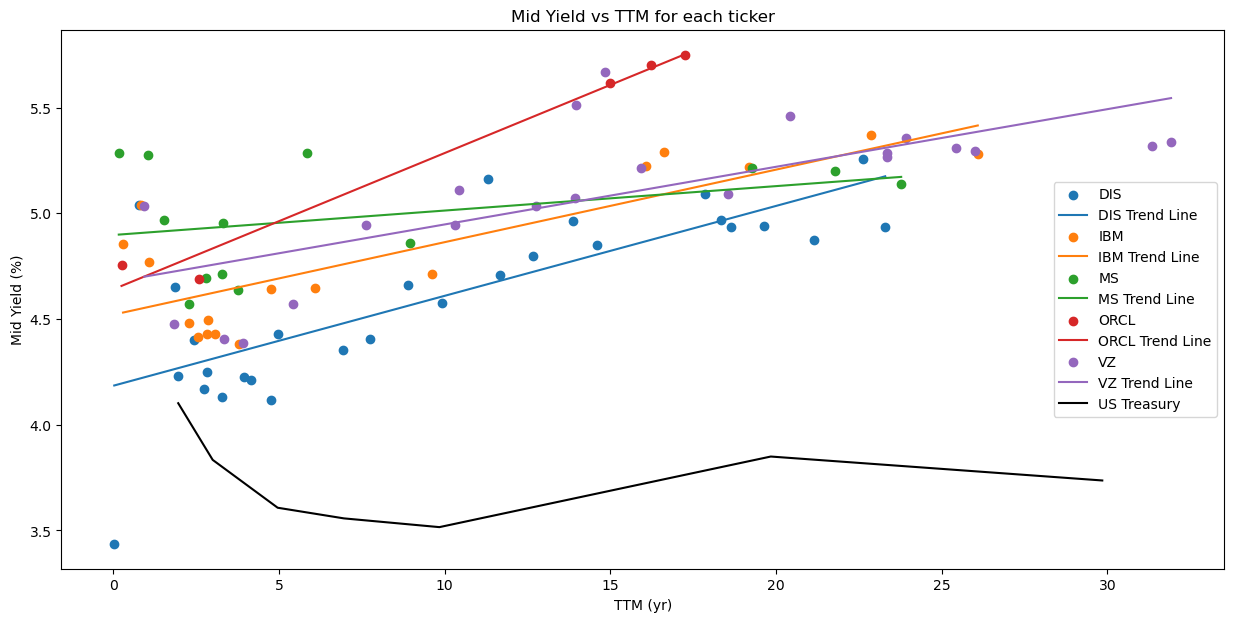

In [184]:
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md3.groupby('ticker'):
    ax.scatter(group['TTM'], group['mid_yield'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['mid_yield'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
#add us treasury mid_yield vs TTM
ax.plot(gov_otr_symbology_md2['TTM'], gov_otr_symbology_md2['mid_yield'], color='black', label='US Treasury')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for each ticker')
plt.legend()
plt.show()

>We can see that the corporate bonds yields are higher than the on-the-run treasury yields, as expected.
>
>These yields are higher to incorporate the credit risk of the issuer.

# Problem 3: Underying treasury benchmarks and credit spreads

## a. Add underlying benchmark bond mid yields

Use the column 'und_bench_yield' to identify the underlying benchmark bond for each issue.

Add two new columns to the joint corporate bond dataframe:

| und_bench_yield | credit_spread |
|----------|-------|

where 

*  `und_bench_yield` = underlying benchmark bond mid yield and
*  `credit_spread` = issue yield - underlying benchmark bond mid yield.

In [185]:
#create a new dataframe adding columns "und_bench_yield" and "credit_spread" to corp_symbology_md1. Use the und_bench_isin column to get the "isin" and use the govt_symbology_md1 dataframe to get the "mid_yield" associated to the "isin" and save it in und_bench_yield column
corp_symbology_md4 = corp_symbology_md1.copy()
corp_symbology_md4['und_bench_yield'] = corp_symbology_md4['und_bench_isin'].map(govt_symbology_md1.set_index('isin')['mid_yield'])
#calculate the credit spread and save it in the column "credit_spread"
corp_symbology_md4['credit_spread'] = corp_symbology_md4['mid_yield'] - corp_symbology_md4['und_bench_yield']

In [186]:
corp_symbology_md4

,ticker,figi,security,name,und_bench_isin,coupon,start_date,maturity,term,TTM,...,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield,und_bench_yield,credit_spread
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,US91282CGM73,6.550,2019-11-22,2033-03-15,13.311431,9.919233,...,US254687DV52,115.163,115.984,115.574,116.174,4.624,4.529,4.576718,3.515423,1.061296
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,US91282CGM73,6.200,2019-11-22,2034-12-15,15.063655,11.671458,...,US254687DZ66,112.939,113.586,113.262,115.380,4.742,4.674,4.707862,3.515423,1.192439
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,US91282CGM73,6.400,2019-11-22,2035-12-15,16.062971,12.670773,...,US254687EB89,114.645,115.438,115.042,117.229,4.838,4.761,4.798171,3.515423,1.282748
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,US91282CGM73,6.150,2019-11-22,2037-03-01,17.273101,13.880903,...,US254687EF93,111.153,112.380,111.767,112.570,5.023,4.908,4.964301,3.515423,1.448878
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,US91282CGM73,6.650,2019-11-22,2037-11-15,17.982204,14.590007,...,US254687EH59,118.135,119.168,118.652,121.478,4.895,4.805,4.849093,3.515423,1.333671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,VZ,BBG00HC11V79,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,US91282CGM73,4.500,2017-08-10,2033-08-10,16.000000,10.324435,...,US92343VEA89,96.081,96.791,96.436,97.286,4.990,4.899,4.944135,3.515423,1.428712
84,VZ,BBG00JKZK9K4,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,US91282CGU99,3.376,2018-01-19,2025-02-15,7.074606,1.842574,...,US92343VEN01,97.932,98.164,98.048,98.639,4.567,4.432,4.477813,4.101802,0.376011
85,VZ,BBG00M1BQWX0,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,US91282CGT27,4.329,2018-10-22,2028-09-21,9.916496,5.440110,...,US92343VER15,98.655,99.025,98.840,99.165,4.611,4.533,4.571809,3.607215,0.964594
86,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,US91282CGU99,0.750,2021-03-22,2024-03-22,3.000684,0.939083,...,US92343VGF58,95.975,96.327,96.151,96.205,5.251,4.846,5.035118,4.101802,0.933316


In [187]:
#drop the rows with credit_spread = NaN
corp_symbology_md5 = corp_symbology_md4.dropna(subset=['credit_spread'])
#sort by TTM in ascending order
corp_symbology_md5.sort_values(by=['TTM'], inplace=True)
#reset index
corp_symbology_md5.reset_index(drop=True, inplace=True)

## b. Credit spread curve plots

Plot a graph/scatter plot of credit spread curves by TTM (one line per issuer).


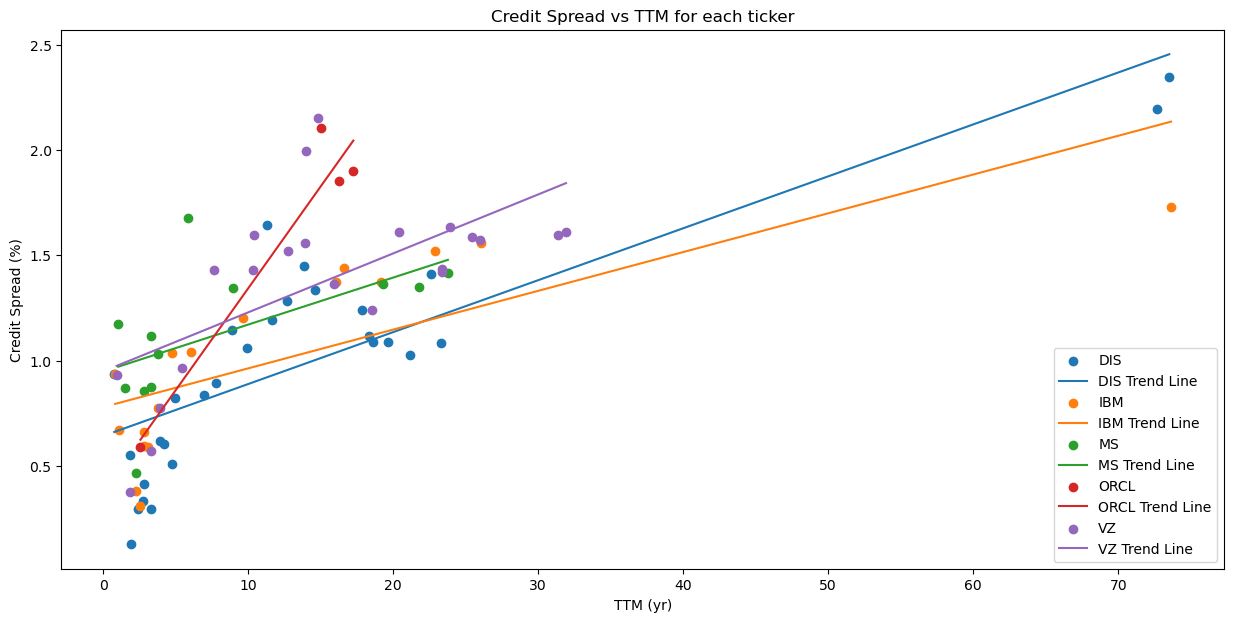

In [188]:
#Plot a graph/scatter plot of credit_spread curves by TTM (one line per ticker/issuer).
#group by the data by ticker and plot the credit_spread vs TTM for each ticker
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md5.groupby('ticker'):
    ax.scatter(group['TTM'], group['credit_spread'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['credit_spread'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Credit Spread (%)')
ax.set_title('Credit Spread vs TTM for each ticker')
plt.legend()
plt.show()

## c. Add g-spreads

Add two new columns to the joint corporate bond dataframe:

| interp_tsy_yield | g_spread |
|----------|-------|

where 

*  `interp_tsy_yield` = interpolated treasury yield (using on-the-run treasuries only), matching the issue maturity
*  `g_spread` = issue yield - interp_tsy_yield.

In [189]:
gov_otr_symbology_md2

,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,2023-04-14,99.5703,99.5820,99.5762,4.105,4.099,4.101802,3.0,1.963039
1,2023-04-14,99.7578,99.7734,99.7656,3.836,3.831,3.833604,3.0,3.003422
2,2023-04-14,100.0703,100.0859,100.0781,3.609,3.606,3.607215,6.0,4.963723
3,2023-04-14,100.3750,100.4375,100.4063,3.563,3.553,3.556821,8.0,6.962355
4,2023-04-14,99.8438,99.8906,99.8672,3.519,3.513,3.515423,11.0,9.842574
5,2023-04-14,100.2969,100.3750,100.3359,3.853,3.847,3.849473,20.0,19.841205
6,2023-04-14,97.9531,98.0313,97.9922,3.739,3.735,3.736185,31.0,29.842574


In [190]:
# Add two new columns to the joint corporate bond dataframe:
# | interp_tsy_yield | g_spread |

def get_interp_yield(df, otr):
    for i in range(len(df)):
        if df['TTM'][i] <= otr['TTM'][0]:
            df['interp_tsy_yield'][i] = otr['mid_yield'][0]
        elif df['TTM'][i] >= otr['TTM'][len(otr)-1]:
            df['interp_tsy_yield'][i] = otr['mid_yield'][len(otr)-1]
        else:
            ttm_temp = df['TTM'][i]
            for j in range(len(otr)):
                if otr['TTM'][j] == ttm_temp:
                    df['interp_tsy_yield'][i] = otr['mid_yield'][j]
                elif otr['TTM'][j] > ttm_temp:
                    df['interp_tsy_yield'][i] = otr['mid_yield'][j-1] + (ttm_temp - otr['TTM'][j-1])*(otr['mid_yield'][j] - otr['mid_yield'][j-1])/(otr['TTM'][j] - otr['TTM'][j-1])
                    break
    return df

In [191]:
corp_symbology_md6 = corp_symbology_md5.copy()
corp_symbology_md6['interp_tsy_yield'] = 0
corp_symbology_md6 = get_interp_yield(corp_symbology_md6, gov_otr_symbology_md2)
corp_symbology_md6['g_spread'] = corp_symbology_md6['mid_yield'] - corp_symbology_md6['interp_tsy_yield']

In [192]:
corp_symbology_md6.tail(10)

,ticker,figi,security,name,und_bench_isin,coupon,start_date,maturity,term,TTM,...,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield,und_bench_yield,credit_spread,interp_tsy_yield,g_spread
74,MS,BBG00FRY86T9,MS 4 3/8 01/22/47,MORGAN STANLEY,US912810TL26,4.375,2017-01-20,2047-01-22,30.004107,23.775496,...,90.301,89.551,90.596,5.201,5.082,5.140857,3.72418,1.416677,3.804908,1.335949
75,VZ,BBG00G6QW816,VZ 5 1/2 03/16/47,VERIZON COMMUNICATIONS,US912810TL26,5.500,2017-03-16,2047-03-16,29.998631,23.920602,...,102.369,101.875,102.364,5.396,5.323,5.358563,3.72418,1.634383,3.803264,1.555299
76,VZ,BBG009PNW3Z2,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,US912810TL26,4.522,2015-08-20,2048-09-15,33.073238,25.423682,...,89.572,89.067,89.482,5.350,5.271,5.310199,3.72418,1.586019,3.786239,1.523960
77,VZ,BBG00GX2GTT1,VZ 5.012 04/15/49,VERIZON COMMUNICATIONS,US912810TL26,5.012,2017-07-06,2049-04-15,31.775496,26.004107,...,96.900,96.004,96.046,5.363,5.231,5.296466,3.72418,1.572286,3.779664,1.516802
78,IBM,BBG00P3BLH50,IBM 4 1/4 05/15/49,IBM CORP,US912810TL26,4.250,2019-05-15,2049-05-15,30.001369,26.086242,...,86.176,85.467,87.273,5.339,5.227,5.281760,3.72418,1.557580,3.778734,1.503027
79,VZ,BBG0083CP816,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,US912810TL26,5.012,2015-03-11,2054-08-21,39.446954,31.353867,...,95.983,95.309,96.103,5.367,5.275,5.320391,3.72418,1.596211,3.736185,1.584206
80,VZ,BBG009PNW578,VZ 4.672 03/15/55,VERIZON COMMUNICATIONS,US912810TL26,4.672,2015-08-20,2055-03-15,39.567420,31.917864,...,90.454,89.855,90.283,5.380,5.295,5.336722,3.72418,1.612542,3.736185,1.600538
81,DIS,BBG00N55NLL7,DIS 7.9 12/01/2095,WALT DISNEY COMPANY/THE,US912810TL26,7.900,2019-03-20,2095-12-01,76.700890,72.632444,...,134.810,132.981,135.987,6.003,5.836,5.918228,3.72418,2.194048,3.736185,2.182043
82,DIS,BBG00N55NPV7,DIS 8 1/4 10/17/2096,WALT DISNEY COMPANY/THE,US912810TL26,8.250,2019-03-20,2096-10-17,77.579740,73.511294,...,136.554,135.471,135.494,6.120,6.021,6.069586,3.72418,2.345406,3.736185,2.333401
83,IBM,BBG00003PFM7,IBM 7 1/8 12/01/2096,IBM CORP,US912810TL26,7.125,1996-12-06,2096-12-01,99.986311,73.634497,...,130.803,130.105,132.816,5.482,5.421,5.451049,3.72418,1.726869,3.736185,1.714864


## d. G-spread curve plots

Plot a graph/scatter plot of g-spread curves by TTM (one line per issuer).


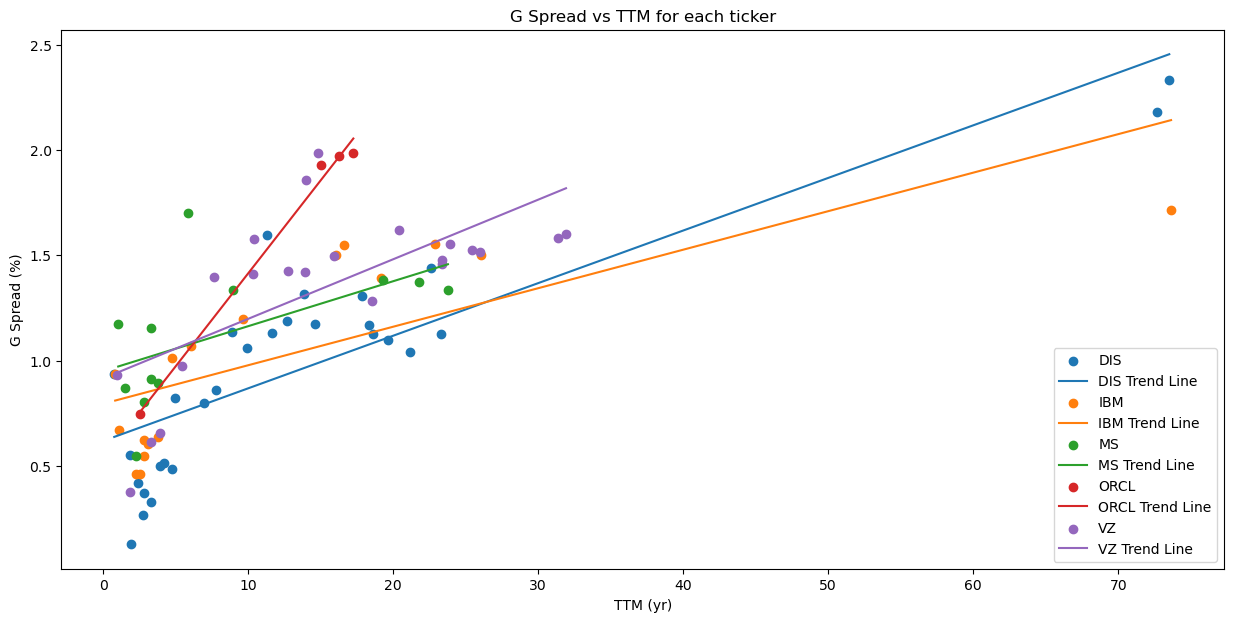

In [193]:
#Plot a graph/scatter plot of g_spread curves by TTM (one line per ticker/issuer).
#group by the data by ticker and plot the g_spread vs TTM for each ticker
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md6.groupby('ticker'):
    ax.scatter(group['TTM'], group['g_spread'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['g_spread'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('G Spread (%)')
ax.set_title('G Spread vs TTM for each ticker')
plt.legend()
plt.show()

# Problem 4: Explore the QuantLib introductory notebook

Try to link concepts discussed in Session 1 to various sections in the notebook. 

Address open questions by consulting the library documentation.

Going forward, we will be using QuantLib for curve calibration (US Treasury + SOFR), as well as pricing and risk of various cash and synthetic credit instruments.

> As seen in our functions above we have used QL library to calculate the yield to maturity of the bonds using the mid prices. This used various functions from the QL library.
>
> Schedule: to create a schedule of the cash flows of the bond
>
> FixedRateBond: to create a fixed rate bond
>
> BondYield: to calculate the yield to maturity of the bond